### Importing libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
import skimage
from skimage.transform import resize
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/asl-alphabet
/kaggle/input/asl-alphabet/asl_alphabet_test
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test
/kaggle/input/asl-alphabet/asl_alphabet_train
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/R
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/space
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/B
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/I
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/del
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/H
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/E
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U
/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train

## Generating train and test data

In [3]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = 87000
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

In [4]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

In [5]:
def data_generation(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    i = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[i] = img_arr
                    y[i] = classes.index(folderName)
                    i += 1
    return X,y
X_train, y_train = data_generation(train_dir)

In [6]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("Image shape : ", X_train[0].shape)

X_train shape :  (87000, 64, 64, 3)
y_train shape :  (87000,)
Image shape :  (64, 64, 3)


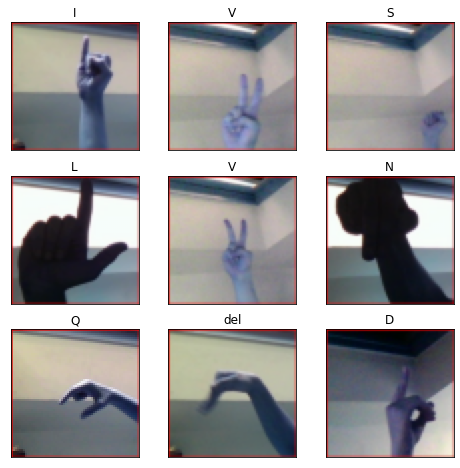

In [7]:
f, axs = plt.subplots(2,2,figsize=(8,8))
for i in range (0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(X_train))
    plt.imshow(X_train[img_nbr])
    plt.title(classes[y_train[img_nbr]])

## Data processing

In [8]:
# copies of the data

X_data = X_train
y_data = y_train

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,stratify=y_data)

In [10]:
# One-Hot-Encoding the categorical data

from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [11]:
# Checking the dimensions of all the variables

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(y_cat_train.shape)
print(y_cat_test.shape)

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


## Model

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [13]:
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(64, 64, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    tf.keras.layers.Dropout(rate=0.3),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(29, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [15]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    X_train, y_cat_train,
    epochs=50,
    batch_size=64,
    verbose=2,
    validation_data=(X_test, y_cat_test),
    callbacks=[early_stop]
)

Epoch 1/50
952/952 - 244s - loss: 1.2079 - accuracy: 0.6346 - val_loss: 0.3229 - val_accuracy: 0.8934
Epoch 2/50
952/952 - 238s - loss: 0.2281 - accuracy: 0.9248 - val_loss: 0.1269 - val_accuracy: 0.9579
Epoch 3/50
952/952 - 241s - loss: 0.1157 - accuracy: 0.9617 - val_loss: 0.0728 - val_accuracy: 0.9782
Epoch 4/50
952/952 - 242s - loss: 0.0790 - accuracy: 0.9748 - val_loss: 0.1059 - val_accuracy: 0.9651
Epoch 5/50
952/952 - 239s - loss: 0.0583 - accuracy: 0.9814 - val_loss: 0.0380 - val_accuracy: 0.9883
Epoch 6/50
952/952 - 238s - loss: 0.0487 - accuracy: 0.9839 - val_loss: 0.0365 - val_accuracy: 0.9893
Epoch 7/50
952/952 - 238s - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.0190 - val_accuracy: 0.9948
Epoch 8/50
952/952 - 238s - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0229 - val_accuracy: 0.9936
Epoch 9/50
952/952 - 244s - loss: 0.0361 - accuracy: 0.9890 - val_loss: 0.0388 - val_accuracy: 0.9879


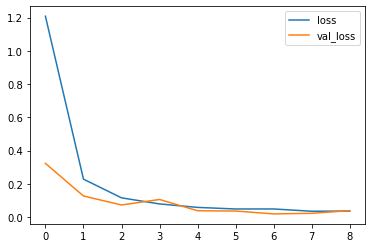

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.show()

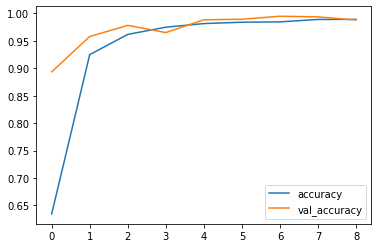

In [18]:
history_df.loc[0:, ['accuracy','val_accuracy']].plot()
plt.show()

## Predictions

In [19]:
# muliclass prediction
predictions = np.argmax(model.predict(X_test), axis=-1)

In [20]:
predictions

array([ 7, 14,  8, ...,  9, 10, 22])

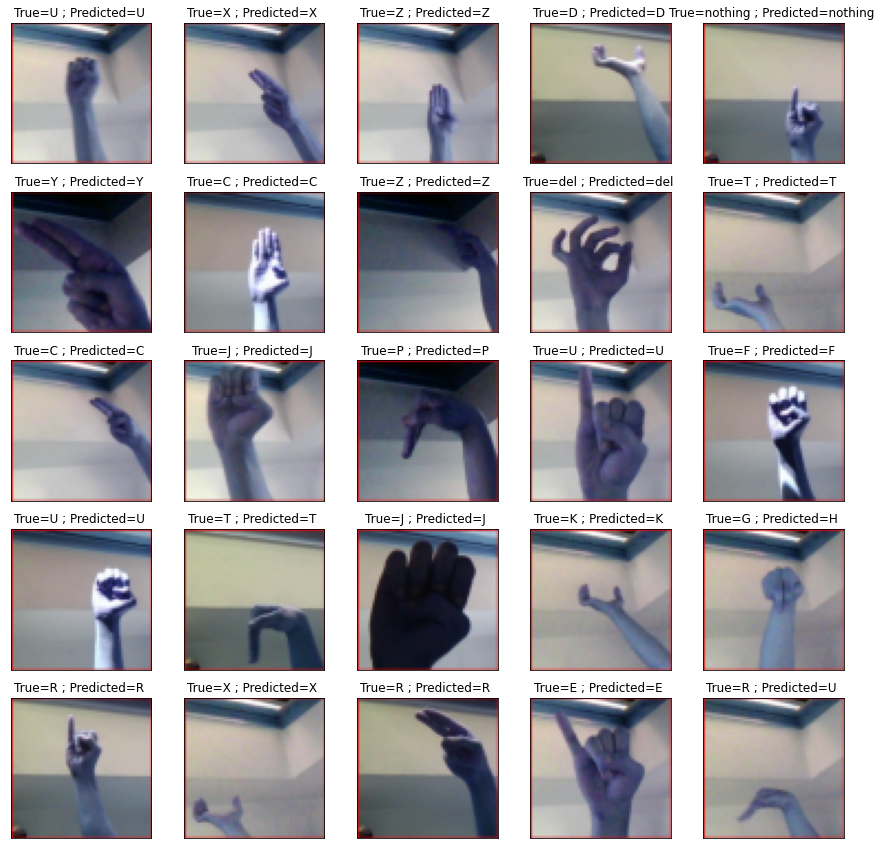

In [21]:
f, axs = plt.subplots(2,2,figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(predictions))
    plt.imshow(X_data[img_nbr])
    plt.title("True={} ; Predicted={} ".format(classes[(y_test[img_nbr])], classes[(predictions[img_nbr])]))

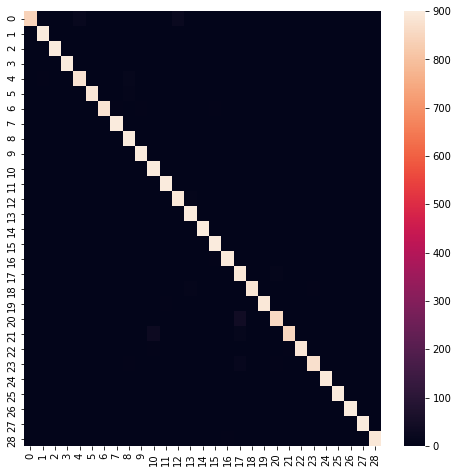

In [22]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       900
           1       0.99      1.00      0.99       900
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900
           4       0.98      0.98      0.98       900
           5       1.00      0.99      0.99       900
           6       1.00      0.98      0.99       900
           7       0.99      1.00      1.00       900
           8       0.97      1.00      0.98       900
           9       0.99      1.00      1.00       900
          10       0.96      1.00      0.98       900
          11       0.99      1.00      1.00       900
          12       0.97      0.99      0.98       900
          13       0.98      1.00      0.99       900
          14       1.00      1.00      1.00       900
          15       0.98      1.00      0.99       900
          16       0.99      0.99      0.99       900
          17       0.93    